# Classifying Emotions in Tweets - MSADS 509 - Applied Text Mining  
**University of San Diego, M.S. Applied Data Science**  
Christopher Robinson, Jose Luis Estrada, Leonid Shpaner  

**GitHub Repository**  
https://github.com/lshpaner/twitter_emotions

### This notebook implements a text mining sentiment analysis project 

### First we fetch the data from google drive

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import string
from string import punctuation
import nltk
import re
import subprocess
from wordcloud import WordCloud 
from collections import Counter, defaultdict
nltk.download('punkt')
from nltk.corpus import stopwords
stop = stopwords.words("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pd.set_option('display.max_rows', None)

### Read data

In [3]:
#Pulling data from Google Drive from Stanford Engineering Computer Science Department's website
def download_gdrive(id, print_stout=True):
  coomand = 'gdown https://drive.google.com/uc?id={}'.format(id)
  returned_value = subprocess.run(coomand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
  if print_stout: print(returned_value.stdout.decode("utf-8"))
  else: print("Download Complete")


train_data = download_gdrive("10rDgl5zAvUdVgSoVngHfwJnf8I1tdpZi", print_stout=True)
test_data = download_gdrive("10qeDcgwdJC76Nv5cCj6WsUYjD6846fEL", print_stout=True)

Downloading...
From: https://drive.google.com/uc?id=10rDgl5zAvUdVgSoVngHfwJnf8I1tdpZi
To: C:\Users\Chris\Desktop\ADS509\Project\train_data.csv
100%|##########| 239M/239M [00:15<00:00, 15.1MB/s] 

Downloading...
From: https://drive.google.com/uc?id=10qeDcgwdJC76Nv5cCj6WsUYjD6846fEL
To: C:\Users\Chris\Desktop\ADS509\Project\test_data.csv
100%|##########| 74.3k/74.3k [00:00<00:00, 3.92MB/s]



In [4]:
#Read train and test sets
columns = ['polarity', 'tweetid', 'date', 'query_name', 'user', 'text']
dftrain = pd.read_csv('train_data.csv',
                      header = None,
                      encoding ='ISO-8859-1')
dftest = pd.read_csv('test_data.csv',
                     header = None,
                     encoding ='ISO-8859-1')
dftrain.columns = columns
dftest.columns = columns

In [5]:
#Sample 1M entries from the training set
dftrain = dftrain.sample(1000000)

### Text pre-processing

In [6]:
#Remove punctuation on texts to just analyze text
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
#Replace url and username's links to tokens URL and USERNAME
class PrePreprocess(object):
    user_pat = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'
    http_pat = '(https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,})'
    repeat_pat, repeat_repl = "(.)\\1\\1+",'\\1\\1'
    def __init__(self):
        pass
    
    def transform(self, X):
        is_pd_series = isinstance(X, pd.core.frame.Series)
        if not is_pd_series:
            pp_text = pd.Series(X)
        else:
            pp_text = X
        pp_text = pp_text.str.replace(pat = self.user_pat, repl = 'USERNAME')
        pp_text = pp_text.str.replace(pat = self.http_pat, repl = 'URL')
        pp_text.str.replace(pat = self.repeat_pat, repl = self.repeat_repl)
        return pp_text
        
    def fit(self, X, y=None):
        return self


### Descriptive statistics 

In [7]:
#Descriptive statistics with function that analyzes number of tokens
def descriptive_stats(tokens, top_num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity 
        (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of 
        tokens, number of unique tokens, lexical diversity, and number of
        characters. 
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        
        # print the five most common tokens
        index = pd.Index(tokens)
        index.value_counts()
        df = pd.DataFrame(index.value_counts())
        top5 = df.head(top_num_tokens)
        print(top5.index.tolist())
        

            
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

def count_words(df, column='tokens', preprocess=None, min_freq=1):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df#.sort_values('freq', ascending=False)


def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], 
            abs(words[largest[i]]*100.0/total)))
            
        
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
            
            
def wordcloud_clusters(model, vectors, features, no_top_words=5):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
                        width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

In [8]:
# Remove Stopwords
dftrain['text'] = dftrain['text'].apply(lambda x: ' '.join([word for word \
    in x.split() if word not in (stop)]))

p = PrePreprocess()
#PRE-Process step
dftrain['tokens'] = p.transform(dftrain['text'])
dftrain['tokens'] = dftrain['tokens'].apply(remove_punctuations)
##word_tokenize 
dftrain['tokens'] = dftrain.apply(lambda row: nltk.word_tokenize(row['tokens']), 
                                  axis=1)

print("DESCRIPTIVE STATS ON Tokens: ")
all = []
#on 100k data
#for li in dftrain['text'].sample(100).iteritems(): all += li[1]
#on all data  
for li in dftrain['tokens'].iteritems(): all += li[1]

descriptive_stats(all, verbose=True)
print("\n")

print("DESCRIPTIVE STATS ON SENTIMENT POLARITY:")
dftrain['polarity'].describe()


DESCRIPTIVE STATS ON Tokens: 
There are 8676094 tokens in the data.
There are 419665 unique tokens in the data.
There are 43095701 characters in the data.
The lexical diversity is 0.048 in the data.
['USERNAME', 'I', 'Im', 'get', 'day']


DESCRIPTIVE STATS ON SENTIMENT POLARITY:


count    1000000.00000
mean           1.99784
std            2.00000
min            0.00000
25%            0.00000
50%            0.00000
75%            4.00000
max            4.00000
Name: polarity, dtype: float64

In [9]:
dftrain.head(10)

,polarity,tweetid,date,query_name,user,text,tokens
341044,0,2014963399,Wed Jun 03 03:15:55 PDT 2009,NO_QUERY,chillysella,"@nadirairdiana nad,jadi nonton pcd? dont watch...","[USERNAME, nadjadi, nonton, pcd, dont, watch, ..."
741824,0,2266376131,Sun Jun 21 08:24:00 PDT 2009,NO_QUERY,iamAlexMcKerrow,"Actually I grasp Trigonometry 3d all, gonna re...","[Actually, I, grasp, Trigonometry, 3d, all, go..."
963790,4,1827470235,Sun May 17 10:46:42 PDT 2009,NO_QUERY,flarrossa,@lisesilveira hey bitch,"[USERNAME, hey, bitch]"
1494963,4,2069827015,Sun Jun 07 16:35:58 PDT 2009,NO_QUERY,iRelvs2lv,@hazyeyez u def dye sounds hot haha,"[USERNAME, u, def, dye, sounds, hot, haha]"
951563,4,1824267900,Sun May 17 00:40:30 PDT 2009,NO_QUERY,stevemanch,@trunty_me_jazzo may ?? Never know,"[USERNAMEmejazzo, may, Never, know]"
1065129,4,1964871845,Fri May 29 14:56:51 PDT 2009,NO_QUERY,Adele_x,@rhea123 lol yep good old days,"[USERNAME, lol, yep, good, old, days]"
988099,4,1834729207,Mon May 18 04:00:31 PDT 2009,NO_QUERY,FieFieSoMajor,@Coodieranks morning boo,"[USERNAME, morning, boo]"
1024864,4,1883348972,Fri May 22 08:24:37 PDT 2009,NO_QUERY,xbeckaxockx,finished sophomore year highschool today. I wi...,"[finished, sophomore, year, highschool, today,..."
449326,0,2069224343,Sun Jun 07 15:29:18 PDT 2009,NO_QUERY,barneygale,BNP seat. #eu09,"[BNP, seat, eu09]"
1218083,4,1989797737,Mon Jun 01 02:50:43 PDT 2009,NO_QUERY,TwittingNala,one exam go!!! semester least,"[one, exam, go, semester, least]"


In [10]:
#Identify positive and negative tweets based on polarity
#Count frequency of tokens used in each dataset
cv = CountVectorizer()
cv.fit(dftrain.text)
neg_doc_matrix = cv.transform(dftrain[dftrain.polarity == 0].text)
pos_doc_matrix = cv.transform(dftrain[dftrain.polarity == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],
                            columns=cv.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
good,18298,38797,57095
it,27122,29015,56137
day,24909,29535,54444
get,28494,22823,51317
like,25747,23259,49006
go,28515,17590,46105
quot,16560,28667,45227
http,15131,29439,44570
today,23685,18600,42285
you,13567,28319,41886


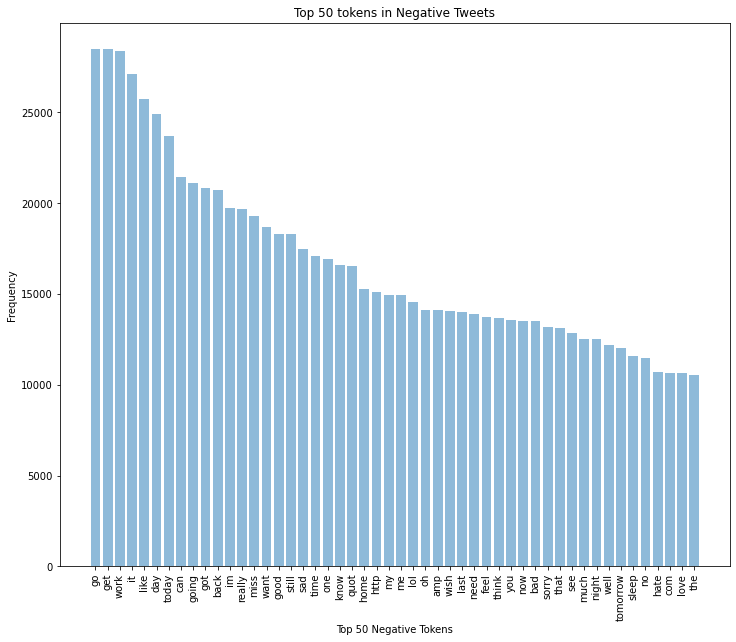

In [11]:
#Show top 50 negative tokens in tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, 
        term_freq_df.sort_values(by='negative',ascending=False)       
                                  ['negative'][:50], 
                                  align='center', 
                                  alpha=0.5)
plt.xticks(y_pos, 
           term_freq_df.sort_values(by='negative',ascending=False) 
                                     ['negative']   
                                     [:50].index,
                                     rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top 50 tokens in Negative Tweets')
plt.xlabel('Top 50 Negative Tokens')
plt.show()

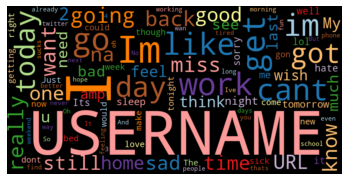

In [12]:
neg_word_freq = count_words(dftrain[dftrain["polarity"] == 0])
wordcloud(neg_word_freq['freq'], max_words=100, 
          stopwords=neg_word_freq.head(50).index)

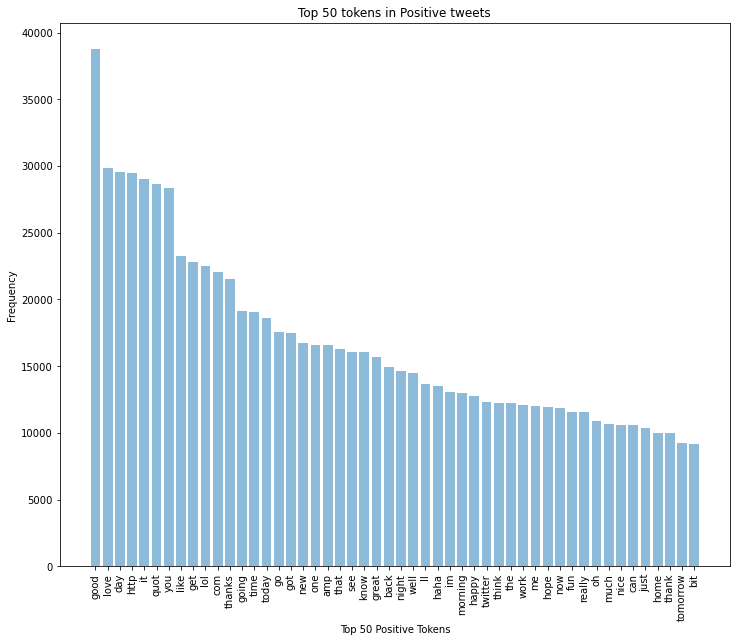

In [13]:
#Show top 50 positive tokens in tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, 
        term_freq_df.sort_values(by='positive',ascending=False)       
                                  ['positive'][:50], 
                                  align='center', 
                                  alpha=0.5)
plt.xticks(y_pos, 
           term_freq_df.sort_values(by='positive',ascending=False) 
                                     ['positive']   
                                     [:50].index,
                                     rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 Positive Tokens')
plt.title('Top 50 tokens in Positive tweets')
plt.show()

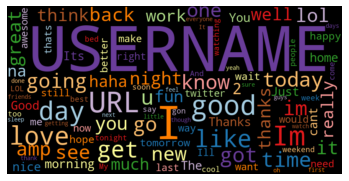

In [14]:
pos_word_freq = count_words(dftrain[dftrain["polarity"] == 4])
wordcloud(pos_word_freq['freq'], max_words=100, 
          stopwords=pos_word_freq.head(50).index)

### Train and test model

In [15]:
#Trained model with logic regression algorithm
sentiment_lr = Pipeline([('pre_processor', p),
                         ('cvect', CountVectorizer(min_df = 50)),
                         ("scaler", preprocessing.StandardScaler(with_mean=False)),
                         ('lr', LogisticRegression())])

sentiment_lr.fit(dftrain.text, dftrain.polarity)


#all test 
Xtest, ytest = dftest.text, dftest.polarity
print(classification_report(ytest,sentiment_lr.predict(Xtest), labels=np.unique(sentiment_lr.predict(Xtest))))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       177
           4       0.49      0.88      0.63       182

   micro avg       0.58      0.81      0.67       359
   macro avg       0.62      0.80      0.68       359
weighted avg       0.62      0.81      0.68       359



In [16]:
# test

class FinalModel:
  def __init__(self, sentiment_model, dangerous_tags):
      self.model = sentiment_model ##LR
      self.tags = dangerous_tags ##LR
  def predict(self, text):
      out = self.model.predict_proba(text)
      print(out)
      score = 0
      if out[0][0] > 0.60: score = -1
      elif out[0][1] > 0.60: score =  1

      tok = self.model.named_steps['cvect'].transform([text])
      word_list = self.model.named_steps['cvect'].get_feature_names_out()
      count_list = tok.toarray().sum(axis=0)
      o = dict(zip(word_list,count_list)) #this is the features used to predict!

      flag = False
      print(text)
      for char in text.split( ): 
          if char in self.tags: flag = True
              

      return (score, flag)

        
dangerous_tags = {"kill","killed", "shoot", "attack", "hurt","gun","guns", \
        "weapon", "die", "bleed", "suicide","shooting","rifle", "choke", \
        "punch","massacre","shooting","pain","revenge","bomb", \
        "destroy","Stick","Knife","Blade","Club","Ax","Sword",\
        "Spear","Halberd","Pike","Lance","Revolver","Rifle", \
        "Shotgun","Semi Automatic Gun","Fully Automatic Gun",\
        "Machine Gun","Crossbow","Flamethrower","Grenade",\
        "Nerve Gas","Mustard Gas","Tear Gas","Pepper Spray", "AR15","AR-15"}

model = FinalModel(sentiment_model=sentiment_lr, dangerous_tags=dangerous_tags)

### Test model with designed examples 

In [17]:

text = "Hello big beautiful world"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I hate this stupid world!!"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I will hurt you tomorrow"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "That movie killed me! It was great"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "Im going to punch the stupid teacher tomorrow!"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I like fruit punch" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "i enjoy to kill zombies on my playstation!" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "Just got out of shooting practice" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "Im bringing my AR15 to hurt everyone" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I like shooting my AR-15 after school" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I am going to shoot you" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I was going shooting tommorow but I hurn my hand." #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

Hello big beautiful world
[[0.06974756 0.93025244]]
Hello big beautiful world
Sentiment score: (1, False) 	 is it dangerous: False


I hate this stupid world!!
[[0.91563958 0.08436042]]
I hate this stupid world!!
Sentiment score: (-1, False) 	 is it dangerous: False


I will hurt you tomorrow
[[0.68821564 0.31178436]]
I will hurt you tomorrow
Sentiment score: (-1, True) 	 is it dangerous: True


That movie killed me! It was great
[[0.53942551 0.46057449]]
That movie killed me! It was great
Sentiment score: (0, True) 	 is it dangerous: False


Im going to punch the stupid teacher tomorrow!
[[0.72408045 0.27591955]]
Im going to punch the stupid teacher tomorrow!
Sentiment score: (-1, True) 	 is it dangerous: True


I like fruit punch
[[0.43423355 0.56576645]]
I like fruit punch
Sentiment score: (0, True) 	 is it dangerous: False


i enjoy to kill zombies on my playstation!
[[0.35594534 0.64405466]]
i enjoy to kill zombies on my playstation!
Sentiment score: (1, True) 	 is it dangerous: F

## Topic Modelling

In [18]:
# Taking a sample from the train data for the topic modelling
Topic_Data = dftrain.sample(10000)

In [19]:
# TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(Topic_Data['text'])
tfidf_text_vectors.shape

(10000, 2050)

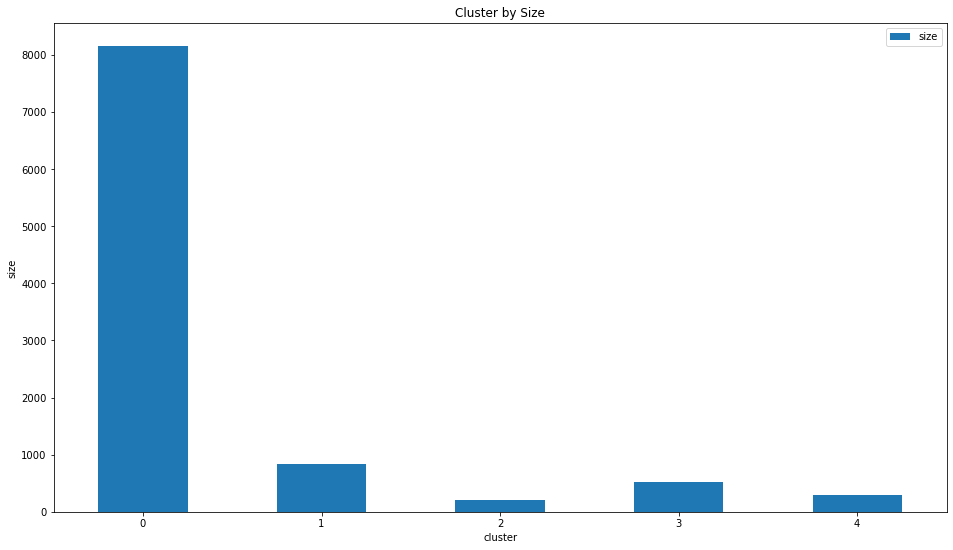

In [20]:
k_means_text = KMeans(n_clusters=5, random_state=42)
model = k_means_text.fit(tfidf_text_vectors)

np.unique(model.labels_, return_counts=True)

sizes = []
for i in range(5):
    sizes.append({"cluster": i, "size": np.sum(model.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
plt.xticks(rotation=0)
plt.title('Cluster by Size')
plt.ylabel('size')
plt.show()

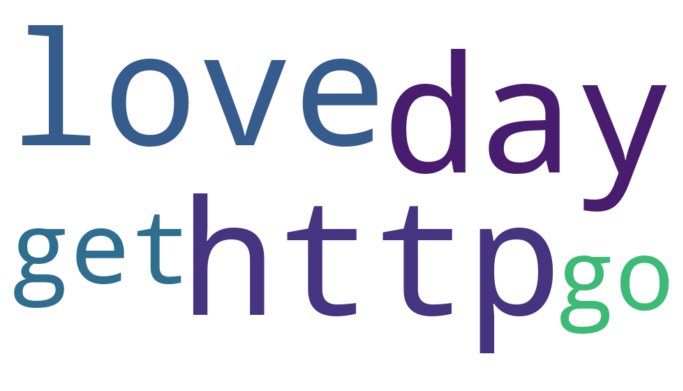

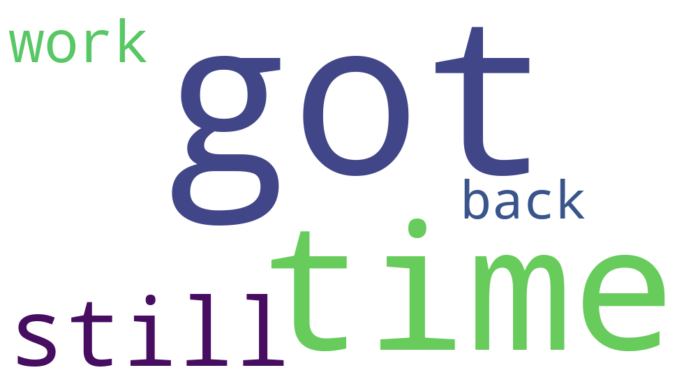

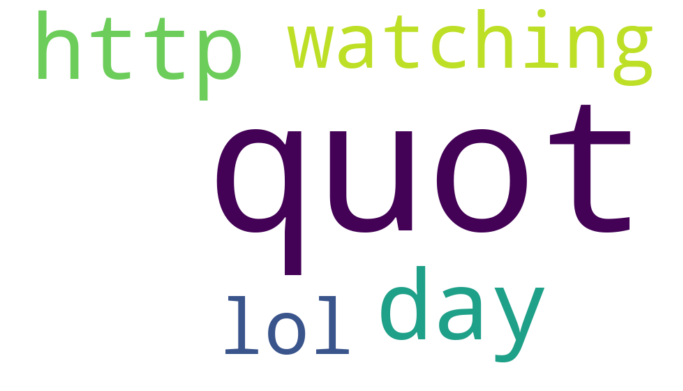

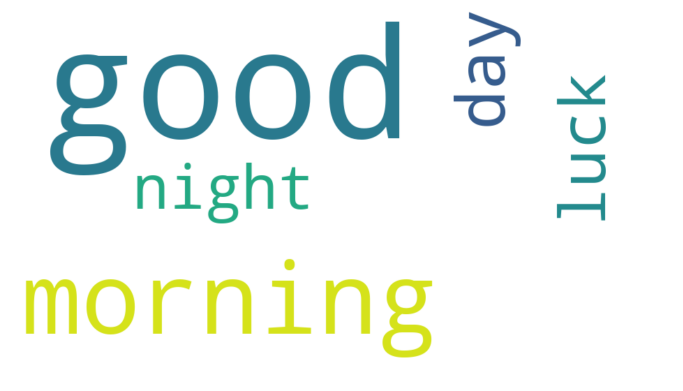

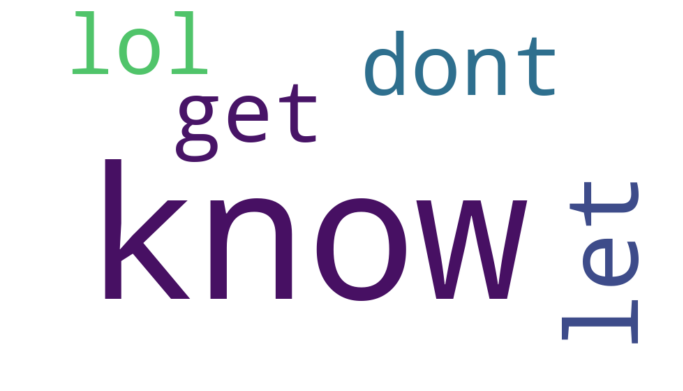

In [21]:
wordcloud_clusters(model, tfidf_text_vectors,
                   tfidf_text_vectorizer.get_feature_names())

In [22]:
# Fitting an LSA Model

svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# call display_topics 
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  good (1.57)
  day (1.35)
  http (1.32)
  com (1.11)
  work (1.06)

Topic 01
  http (21.98)
  com (19.50)
  twitpic (14.05)
  ly (4.34)
  bit (4.10)

Topic 02
  thanks (212.44)
  quot (39.01)
  love (25.33)
  know (11.41)
  much (10.75)

Topic 03
  quot (30.24)
  love (2.77)
  back (2.72)
  like (2.57)
  lol (2.55)

Topic 04
  quot (16.66)
  good (15.91)
  morning (8.83)
  day (3.94)
  luck (1.28)
